In [95]:
import pandas as pd
import json
import os

files = os.listdir("results")

json_files = {}
for file in files:
    if file[-4:] != "json":
        continue
    with open("results/"+file, "r") as f:
        
        df = pd.DataFrame(json.load(f))
        idx = file.split("_")[1][3:]
        df["idx"] = int(idx)
        json_files[file] = df

df = pd.concat(json_files.values(), axis = 0)
df = df[df["idx"] != 5]
df

,tensor_location,criterion_score,layer_name,value_before,value_after,idx
0,"[0, 0, 593]",0.7608,class_token,-0.000760,0.000760,0
1,"[0, 0, 67]",0.7608,class_token,-0.000703,0.000703,0
2,"[0, 0, 690]",0.7608,class_token,-0.000758,0.000758,0
3,"[0, 0, 418]",0.7608,class_token,-0.000655,0.000655,0
4,"[0, 0, 583]",0.7608,class_token,-0.000602,0.000602,0
...,...,...,...,...,...,...
1515,[131],0.7608,heads.head.bias,-0.013511,-0.216172,6
1516,[576],0.7608,heads.head.bias,-0.028518,-0.456286,6
1517,[703],0.7608,heads.head.bias,0.006955,0.000435,6
1518,[361],0.7608,heads.head.bias,0.010427,0.166830,6


In [96]:
majority_class = df[df['idx'] == 0]

# Downsample to 6080
majority_sampled = majority_class.sample(n=6080, random_state=42)

# Combine with the rest
df = pd.concat([
    majority_sampled,
    df[df['idx'] != 0]
])

In [97]:
import numpy as np

df["test_delta"] = 0.7608 - df["criterion_score"]

result = df.groupby("idx").agg(
    criterion_score_mean=("criterion_score", "mean"),
    test_delta_mean=("test_delta", "mean"),
    test_delta_std=("test_delta", "std"),
    critical_error_pct=("criterion_score", lambda x: np.mean(x < 0.1)),
    n_samples=("criterion_score", "count")  # or use any column
)
display(result)

result.to_latex()

,criterion_score_mean,test_delta_mean,test_delta_std,critical_error_pct,n_samples
idx,,,,,
0,0.760769,0.000031,0.000736,0.000000,6080
1,0.173744,0.587056,0.305324,0.743582,6232
3,0.760798,0.000002,0.000180,0.000000,4560
6,0.760128,0.000672,0.020291,0.000822,6080
10,0.760796,0.000004,0.000077,0.000000,6080
15,0.760800,0.000000,0.000000,0.000000,6080
21,0.760800,0.000000,0.000000,0.000000,6080


'\\begin{tabular}{lrrrrr}\n\\toprule\n & criterion_score_mean & test_delta_mean & test_delta_std & critical_error_pct & n_samples \\\\\nidx &  &  &  &  &  \\\\\n\\midrule\n0 & 0.760769 & 0.000031 & 0.000736 & 0.000000 & 6080 \\\\\n1 & 0.173744 & 0.587056 & 0.305324 & 0.743582 & 6232 \\\\\n3 & 0.760798 & 0.000002 & 0.000180 & 0.000000 & 4560 \\\\\n6 & 0.760128 & 0.000672 & 0.020291 & 0.000822 & 6080 \\\\\n10 & 0.760796 & 0.000004 & 0.000077 & 0.000000 & 6080 \\\\\n15 & 0.760800 & 0.000000 & 0.000000 & 0.000000 & 6080 \\\\\n21 & 0.760800 & 0.000000 & 0.000000 & 0.000000 & 6080 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [98]:
df.dtypes

tensor_location     object
criterion_score    float64
layer_name          object
value_before       float64
value_after        float64
idx                  int64
test_delta         float64
dtype: object

In [99]:
df['tensor_location'] = df['tensor_location'].astype(str).astype('|S') # which will by default set the length to the max len it encounters
df['layer_name'] = df['layer_name'].astype('|S') # which will by default set the length to the max len it encounters
df['idx'] = df['idx'].astype('|S') # which will by default set the length to the max len it encounters
df.dtypes

tensor_location       |S16
criterion_score    float64
layer_name            |S62
value_before       float64
value_after        float64
idx                   |S21
test_delta         float64
dtype: object

In [100]:
df = df.sort_values(by = ["layer_name", "idx", "tensor_location", "criterion_score"]).reset_index(drop = True)
df

,tensor_location,criterion_score,layer_name,value_before,value_after,idx,test_delta
0,"b'[0, 0, 135]'",0.7608,b'class_token',-0.000868,0.000868,b'0',0.0000
1,"b'[0, 0, 16]'",0.7608,b'class_token',-0.000807,0.000807,b'0',0.0000
2,"b'[0, 0, 176]'",0.7608,b'class_token',-0.000473,0.000473,b'0',0.0000
3,"b'[0, 0, 227]'",0.7608,b'class_token',-0.002646,0.002646,b'0',0.0000
4,"b'[0, 0, 228]'",0.7608,b'class_token',-0.000710,0.000710,b'0',0.0000
...,...,...,...,...,...,...,...
41187,"b'[81, 527]'",0.7608,b'heads.head.weight',-0.014841,-0.237464,b'6',0.0000
41188,"b'[838, 544]'",0.7610,b'heads.head.weight',0.025741,0.411856,b'6',-0.0002
41189,"b'[868, 656]'",0.7608,b'heads.head.weight',-0.003590,-0.000224,b'6',0.0000
41190,"b'[903, 296]'",0.7608,b'heads.head.weight',-0.028036,-0.448577,b'6',0.0000


<Axes: xlabel='idx', ylabel='criterion_score'>

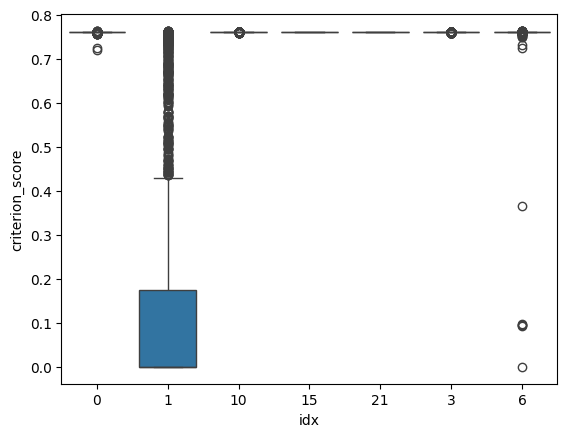

In [101]:
import seaborn as sns

sns.boxplot(data = df, x = "idx", y = "criterion_score")

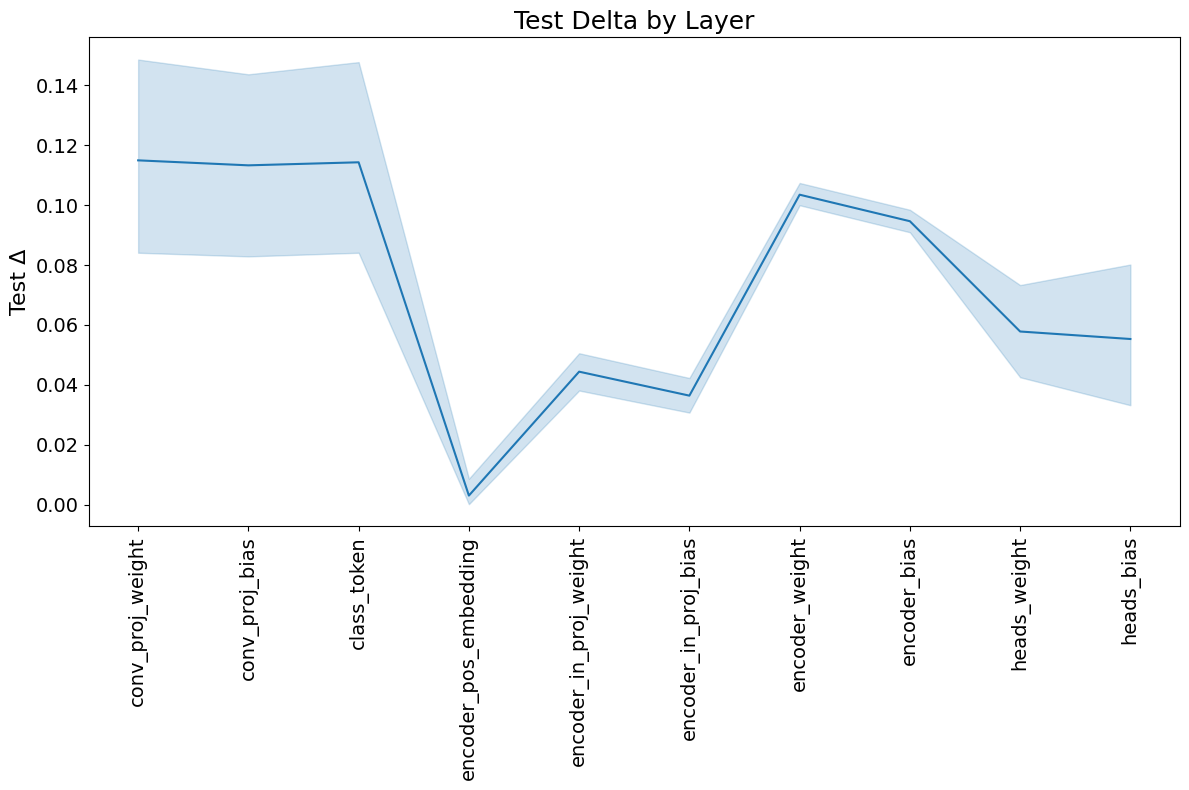

         layer_name_short  mean_test_delta  count  std_test_delta
0        conv_proj_weight         0.114951    271        0.272765
1          conv_proj_bias         0.113286    275        0.271115
2             class_token         0.114303    273        0.271866
3   encoder_pos_embedding         0.003045    273        0.045980
4  encoder_in_proj_weight         0.044406   3236        0.175918
5    encoder_in_proj_bias         0.036405   3255        0.160706
6          encoder_weight         0.103489  16547        0.255779
7            encoder_bias         0.094633  16517        0.250886
8            heads_weight         0.057817    270        0.137097
9              heads_bias         0.055313    275        0.197656


C:\Users\wwden\AppData\Local\Temp\ipykernel_18912\684760099.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_table = df.groupby("layer_name_short")["test_delta"].agg(


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create short layer names
df["layer_name_short"] = df["layer_name"].astype(str).apply(
    lambda x: "_".join([x.split(".")[0], x.split(".")[-1]]) if "." in x else x
)

# Define custom forward pass order (based on ViT-B_32 architecture)
forward_order = [
    "conv_proj_weight",
    "conv_proj_bias",
    "class_token",
    "encoder_pos_embedding",
    "encoder_in_proj_weight",
    "encoder_in_proj_bias",
    "encoder_weight",
    "encoder_bias",
    "heads_weight",
    "heads_bias"
]

# Ensure the column is categorical with the correct order
df["layer_name_short"] = pd.Categorical(df["layer_name_short"], categories=forward_order, ordered=True)
df = df.sort_values("layer_name_short")

# Plot
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x="layer_name_short", y="test_delta")
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("", fontsize=16)
plt.ylabel("Test Δ", fontsize=16)
plt.title("Test Delta by Layer", fontsize=18)
plt.tight_layout()
plt.show()



agg_table = df.groupby("layer_name_short")["test_delta"].agg(
    mean_test_delta="mean",
    count="size",
    std_test_delta="std"
).reset_index()

print(agg_table)


In [89]:
import torchvision.models as models

model = models.vit_b_32(pretrained=True)

# Access key components of the ViT model (from torchvision source code):
# - conv_proj (patch embedding conv)
# - encoder (transformer encoder)
# - class_token (parameter)
# - encoder.pos_embedding (positional embedding)

print("Forward pass order components:\n")

print("conv_proj:")
print(model.conv_proj)  # conv patch embedding

print("\nclass_token:")
print(model.class_token.shape)

print("\npos_embedding:")
print(model.encoder.pos_embedding.shape)

print("\nEncoder blocks:")
for i, block in enumerate(model.encoder.layers):
    print(f"  Encoder block {i}: {block}")

print("\nHeads / output layers:")
print(model.heads)


c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Forward pass order components:

conv_proj:
Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))

class_token:
torch.Size([1, 1, 768])

pos_embedding:
torch.Size([1, 50, 768])

Encoder blocks:
  Encoder block 0: EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)
  Encoder block 1: EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, 

In [90]:
df["idx"].value_counts()

C:\Users\wwden\AppData\Local\Temp\ipykernel_18912\2608930675.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df["idx"].value_counts()


idx
b'0'     10640
b'1'      6232
b'6'      6080
b'21'     6080
b'15'     6080
b'10'     6080
b'3'      4560
Name: count, dtype: int64

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Precompute regression
X = df["log_delta"].values.reshape(-1, 1)
y = df["criterion_score"].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)
slope = reg.coef_[0]
intercept = reg.intercept_

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="log_delta", y="criterion_score", hue="idx", alpha=0.3, s=10, linewidth=0)

# Overlay regression line
sns.lineplot(x=df["log_delta"], y=y_pred, color='black', linewidth=2, label=f"y={slope:.2f}x+{intercept:.2f}\n$R^2$={r2:.3f}")

plt.title("Log Delta vs Criterion Score with Regression")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'log_delta'

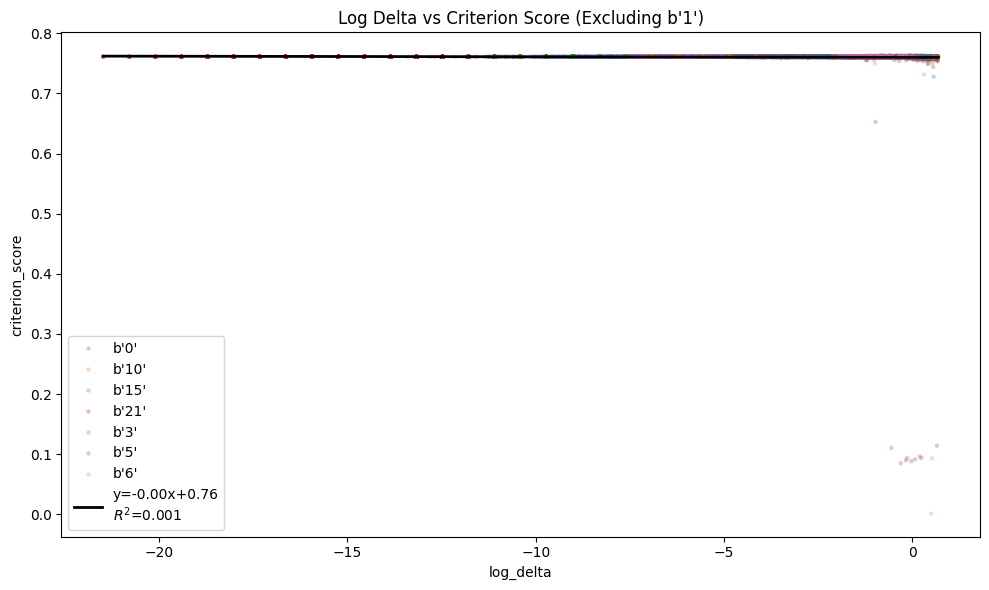

In [ ]:
# Filter out b'1' from idx
df_filtered = df[df["idx"] != b'1']

# Recompute regression
X_filt = df_filtered["log_delta"].values.reshape(-1, 1)
y_filt = df_filtered["criterion_score"].values
reg_filt = LinearRegression().fit(X_filt, y_filt)
y_pred_filt = reg_filt.predict(X_filt)
r2_filt = r2_score(y_filt, y_pred_filt)
slope_filt = reg_filt.coef_[0]
intercept_filt = reg_filt.intercept_

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="log_delta", y="criterion_score", hue="idx", alpha=0.3, s=10, linewidth=0)

# Overlay regression line
sns.lineplot(x=df_filtered["log_delta"], y=y_pred_filt, color='black', linewidth=2,
             label=f"y={slope_filt:.2f}x+{intercept_filt:.2f}\n$R^2$={r2_filt:.3f}")

plt.title("Log Delta vs Criterion Score (Excluding b'1')")
plt.legend()
plt.tight_layout()
plt.show()
